In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import tensorflow as tf
import keras
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
import seaborn as sns
from sklearn.compose import ColumnTransformer
from statistics import stdev
from keras import regularizers

In [ ]:
df_raw = pd.read_csv("/content/lithium-ion batteries.csv")

In [ ]:
df_raw.head()

,Materials Id,Formula,Spacegroup,Formation Energy (eV),E Above Hull (eV),Band Gap (eV),Nsites,Density (gm/cc),Volume,Has Bandstructure,Crystal System
0,mp-849394,Li2MnSiO4,Pc,-2.699,0.006,3.462,16,2.993,178.513,True,monoclinic
1,mp-783909,Li2MnSiO4,P21/c,-2.696,0.008,2.879,32,2.926,365.272,True,monoclinic
2,mp-761311,Li4MnSi2O7,Cc,-2.775,0.012,3.653,28,2.761,301.775,True,monoclinic
3,mp-761598,Li4Mn2Si3O10,C2/c,-2.783,0.013,3.015,38,2.908,436.183,True,monoclinic
4,mp-767709,Li2Mn3Si3O10,C2/c,-2.747,0.016,2.578,36,3.334,421.286,True,monoclinic


In [ ]:
data = df_raw # temporary save

In [ ]:
data = data.drop(['Materials Id'], axis=1)

In [ ]:
# Preprocessing of the data

numerical_transformer = StandardScaler()
label_transformer = OrdinalEncoder()

n_cols = [c for c in data.columns if data[c].dtype in ['int64', 'float64', 'int32', 'float32']]
obj_cols = [c for c in data.columns if data[c].dtype in ['object', 'bool']]
print(n_cols, obj_cols)

ct = ColumnTransformer([('num', numerical_transformer, n_cols), ('non_num', label_transformer, obj_cols),])
processed = ct.fit_transform(data)
new_data = pd.DataFrame(columns=data.columns, data=processed)
new_data.head()

['Formation Energy (eV)', 'E Above Hull (eV)', 'Band Gap (eV)', 'Nsites', 'Density (gm/cc)', 'Volume'] ['Formula', 'Spacegroup', 'Has Bandstructure', 'Crystal System']


,Formula,Spacegroup,Formation Energy (eV),E Above Hull (eV),Band Gap (eV),Nsites,Density (gm/cc),Volume,Has Bandstructure,Crystal System
0,-0.447048,-1.722253,1.272374,-0.988690,0.025455,-0.989769,54.0,31.0,1.0,0.0
1,-0.430703,-1.656286,0.735721,-0.296020,-0.164107,-0.350714,54.0,21.0,1.0,0.0
2,-0.861132,-1.524351,1.448190,-0.469187,-0.630939,-0.567989,81.0,6.0,1.0,0.0
3,-0.904720,-1.491367,0.860909,-0.036268,-0.215034,-0.108070,79.0,1.0,1.0,0.0
4,-0.708575,-1.392416,0.458650,-0.122852,0.990242,-0.159045,48.0,1.0,1.0,0.0


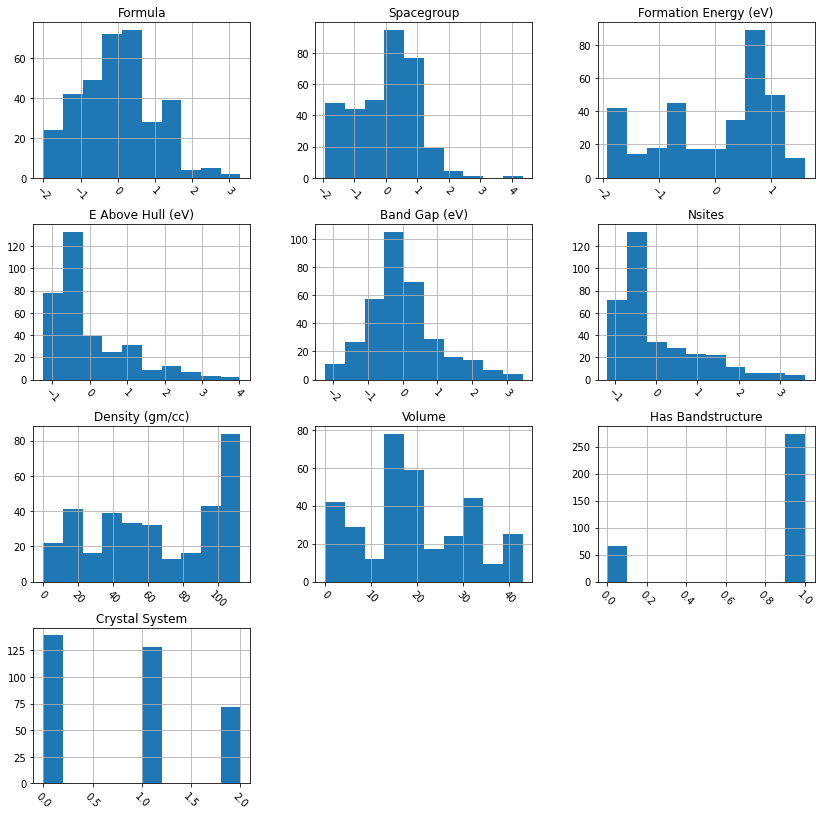

In [ ]:
# Data Visualization

new_data.hist(figsize=(14,14), xrot=-45)
plt.show()

In [ ]:
X = new_data.drop('Crystal System', axis=1)
y = new_data['Crystal System']
print(X.shape)
print(y.shape)

(339, 9)
(339,)


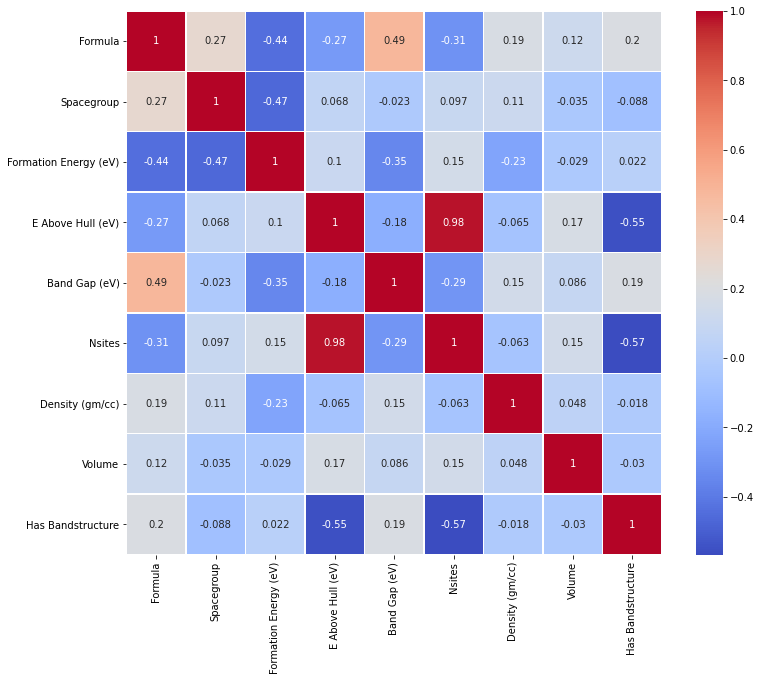

In [ ]:
plt.figure(figsize=(12, 10))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, lw=0.5, cmap='coolwarm', annot=True)

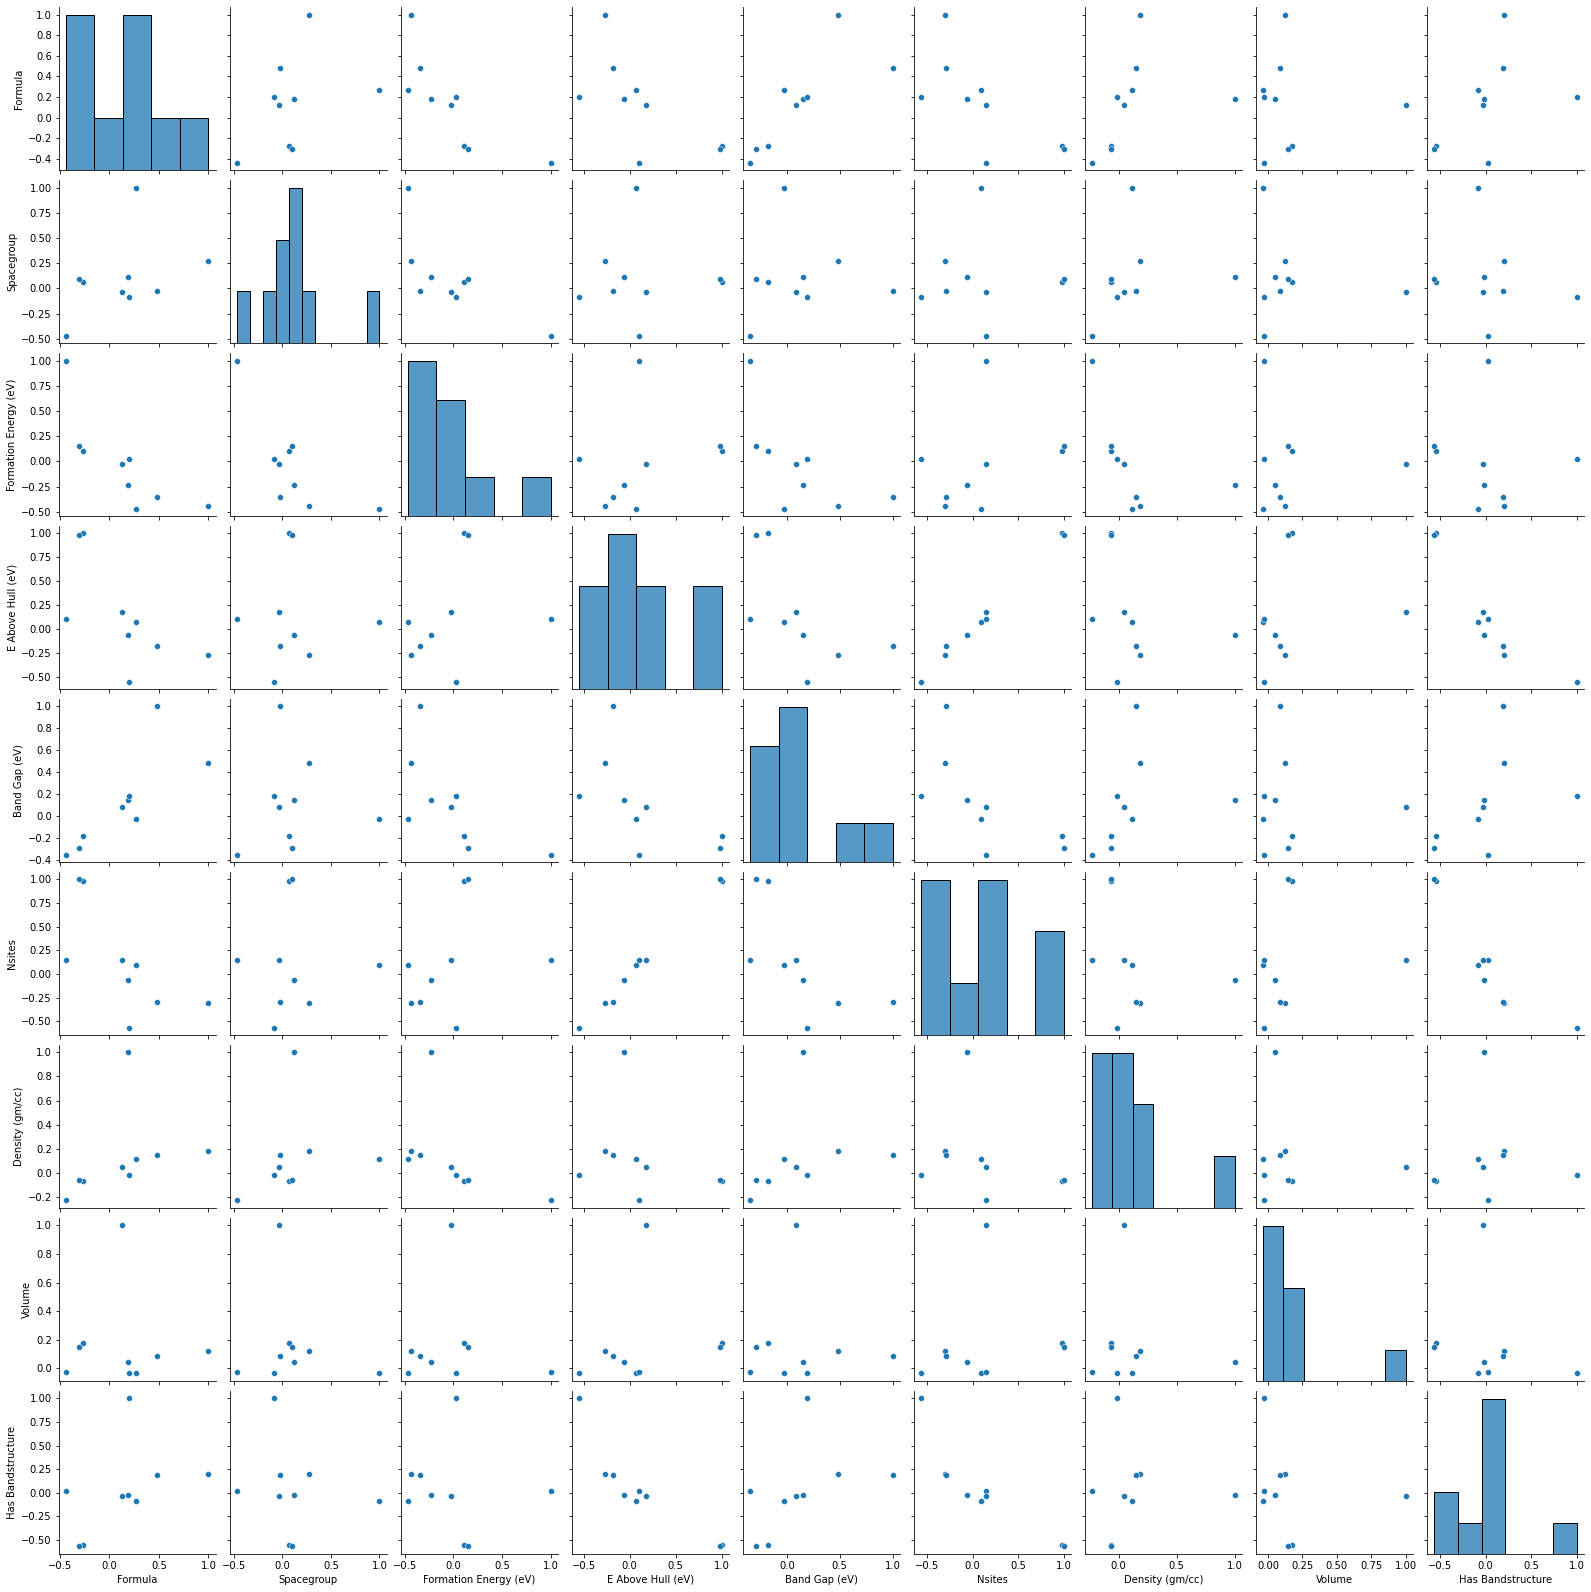

In [ ]:
corr_matrix = X.corr()
sns.pairplot(corr_matrix)

In [ ]:
#Training the model


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Average score: 0.726470588235294
Standard deviation: 0.06873057267789742


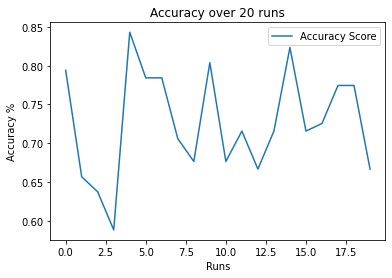

In [ ]:
def train_model(n_runs, t_size=0.25):
    score = []
    for j in range(n_runs):
        X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=t_size, shuffle=True)
        y_encoded = to_categorical(y_train)
        model = Sequential()
        model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dropout(0.2))
        model.add(Dense(128, activation='softsign', kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dropout(0.2))
        model.add(Dense(3, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        global history 
        history = model.fit(X_train, y_encoded, epochs=100, verbose=False, validation_split=0.2)

        preds=model.predict_classes(X_test)

        score.append(accuracy_score(y_test, preds))
            
    print(f'Average score: '+ str(sum(score)/len(score)))
    print(f'Standard deviation: ' + str(stdev(score)))
    
    plt.title('Accuracy over ' + str(n_runs) + ' runs')
    plt.plot(score, label='Accuracy Score')
    plt.ylabel('Accuracy %')
    plt.xlabel('Runs')
    plt.legend()
    plt.show()
    
train_model(20, 0.3)

        

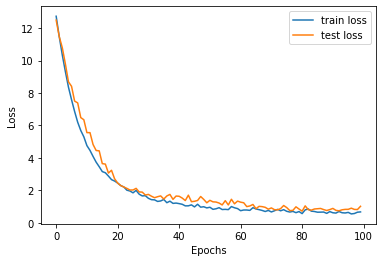

In [ ]:
#  Plotting the result scores

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()


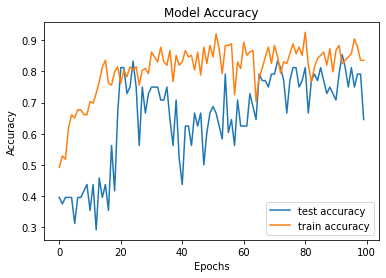

In [ ]:
plt.title('Model Accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()